In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.interpolate import interp1d

In [2]:
def fast_SST(X, dT, Nv, Nt, gamma):
    X[torch.isnan(X)] = 0

    Z_Ts = torch.zeros(Nv, Nt)

    omega = torch.angle(X[:, 1:] * torch.conj(X[:, :-1])) / (2 * torch.pi * dT)
    omega = torch.cat((omega[:, 0].unsqueeze(1), omega), dim=1)

    gamma = gamma * torch.max(torch.abs(X), dim=0).values

    for b in range(Nt):  # time
        for eta in range(Nv):  # frequency
            if torch.abs(X[eta, b]) >= gamma[b]:
                k = torch.argmin(torch.abs(omega[eta, b] - omega[:, b]))
                Z_Ts[eta, b] = Z_Ts[eta, b] + torch.mean(X[k, b])

    return Z_Ts


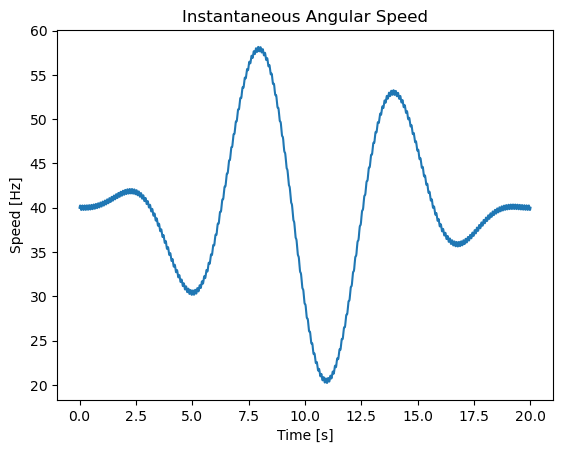

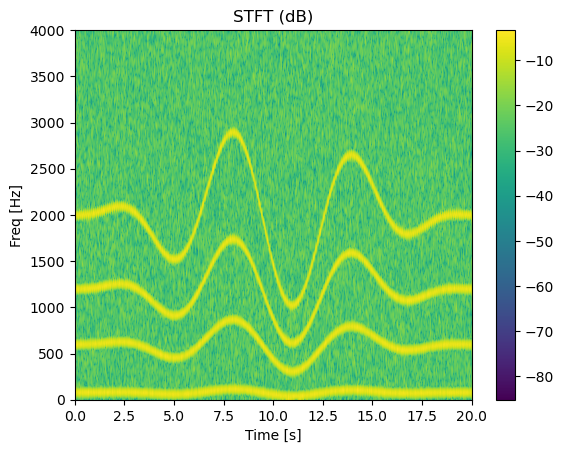

/tmp/ipykernel_18697/3381279985.py:53: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10 * np.log10(ST.numpy()), extent=[0, Aquisition_time, 0, Fs], aspect='auto', origin='lower')


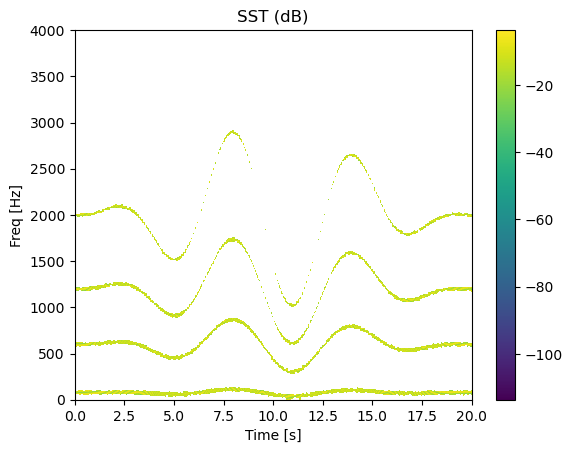

tensor([[0.1851, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1830, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1765, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [8]:
Fs = 4000
Aquisition_time = 20
L = int(Aquisition_time * Fs)
t = np.arange(0, Aquisition_time, 1/Fs)

speed = 20 * np.sin(t) * np.hanning(L) + 40 + 0.25 * np.sin(2 * np.pi * 10 * t)

plt.figure()
plt.plot(t, speed, linewidth=1.5)
plt.xlabel('Time [s]')
plt.ylabel('Speed [Hz]')
plt.title('Instantaneous Angular Speed')
plt.show()

phase = np.cumsum(speed)

x = np.sin(2 * np.pi * (phase / Fs + 2 * np.pi * np.random.rand(L) / Fs))
x = x + np.sin(2 * np.pi * (7.5 * phase / Fs + 2 * np.pi * np.random.rand(L) / Fs))
x = x + np.sin(2 * np.pi * (15 * phase / Fs + 2 * np.pi * np.sqrt(5) * np.random.rand(L) / Fs))
x = x + np.sin(2 * np.pi * (25 * phase / Fs + 2 * np.pi * np.sqrt(10) * np.random.rand(L) / Fs))

P0 = np.mean(x**2)
SNR_noise = 5
SNR = 10**(SNR_noise / 10)
x = x + np.sqrt(P0 / SNR) * np.random.randn(L)

gamma = 0.5

win = int(0.05 * Fs)
noverlap = int(0.5 * win)
Nfft = Fs

F, T, S = stft(x, fs=Fs, nperseg=win, noverlap=noverlap, nfft=Nfft)

# S of shape [NF,NT]

dT = T[1] - T[0]
S = torch.tensor(S)

SST = fast_SST(S, dT, len(F), len(T), gamma)

STFT = torch.abs(S)**2
plt.figure()
plt.imshow(10 * np.log10(STFT.numpy()), extent=[0, Aquisition_time, 0, Fs], aspect='auto', origin='lower')
plt.ylabel('Freq [Hz]')
plt.xlabel('Time [s]')
plt.title('STFT (dB)')
plt.colorbar()
plt.show()

ST = torch.abs(SST)**2
plt.figure()
plt.imshow(10 * np.log10(ST.numpy()), extent=[0, Aquisition_time, 0, Fs], aspect='auto', origin='lower')
plt.ylabel('Freq [Hz]')
plt.xlabel('Time [s]')
plt.title('SST (dB)')
plt.colorbar()
plt.show()

print(SST)

In [9]:
nST = ST.numpy()
nST[nST == 0] = nST[nST>0].min()/2

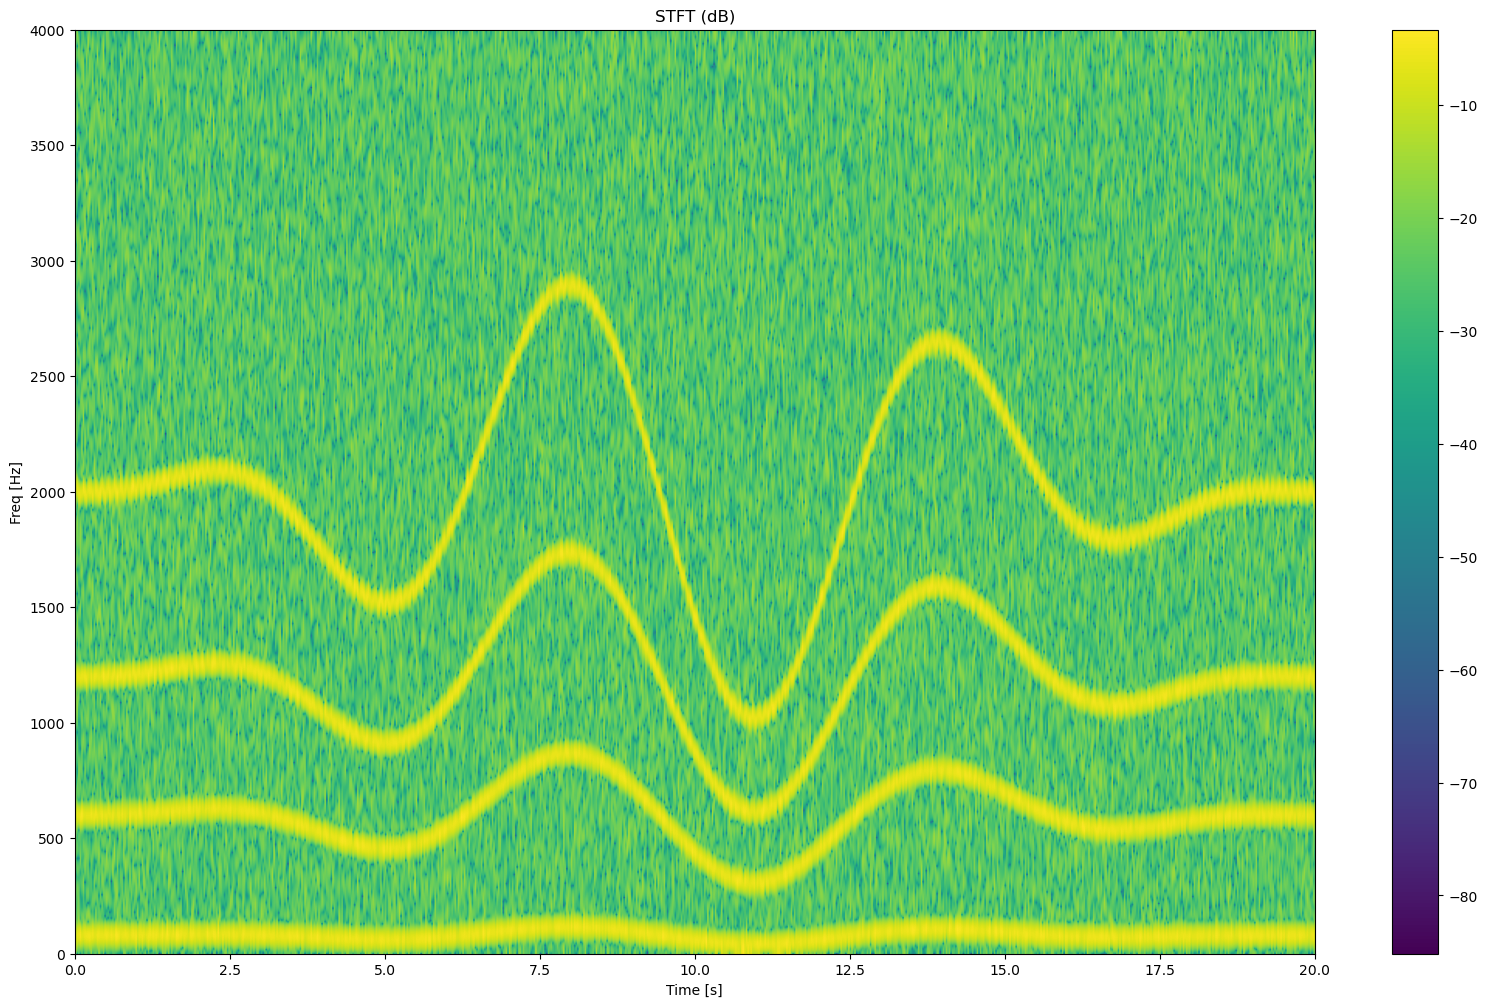

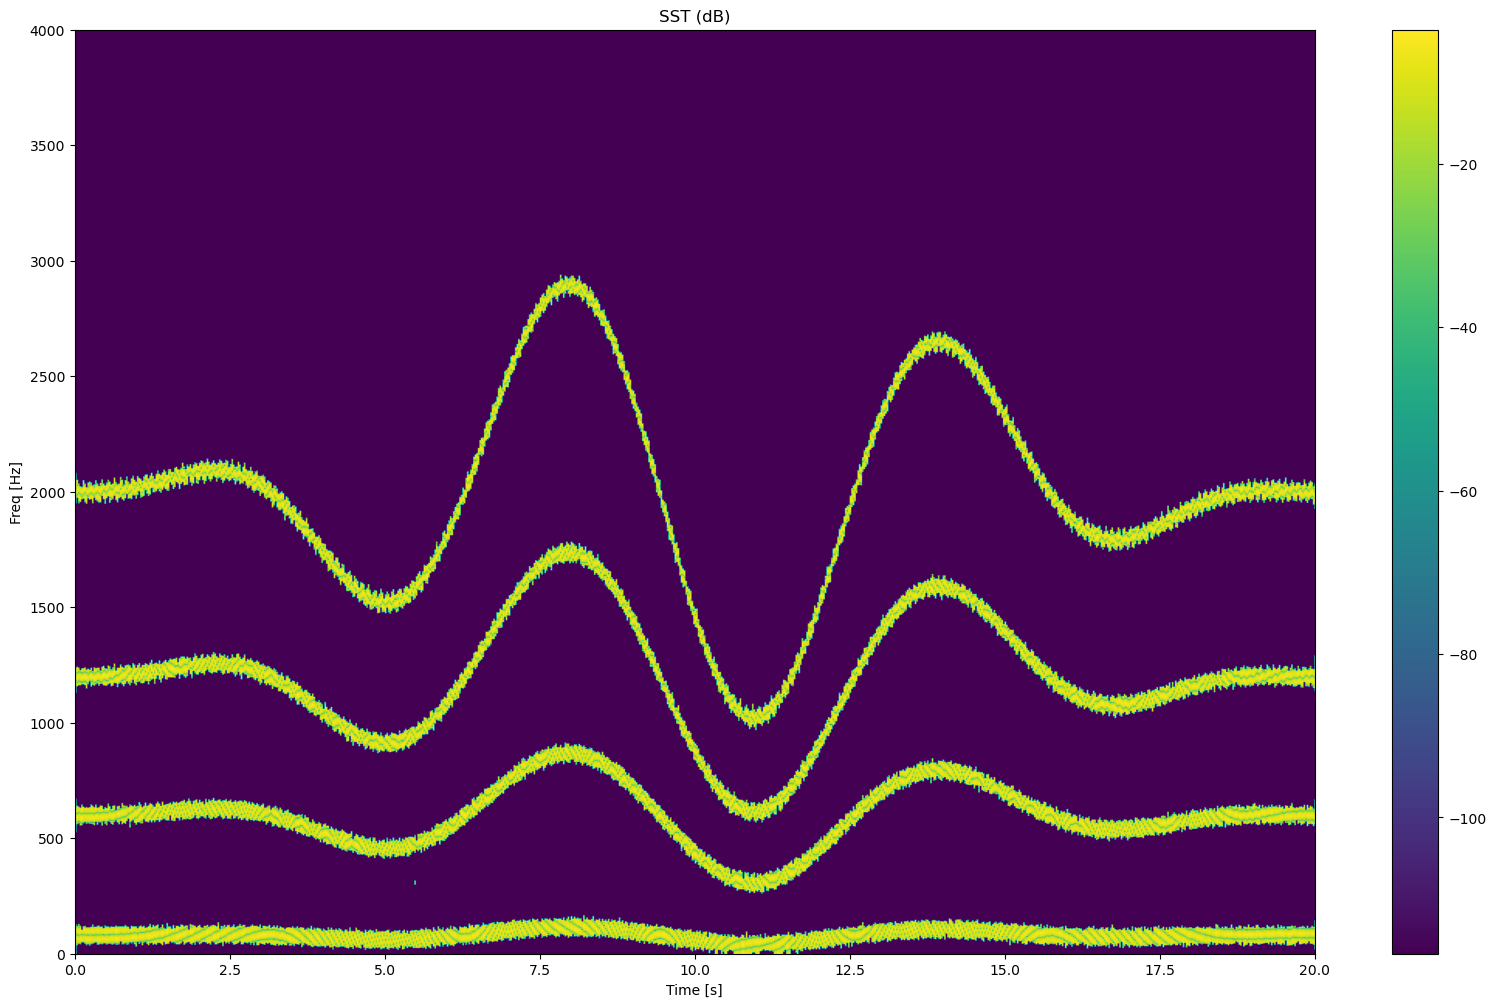

In [10]:
plt.figure(figsize=(20, 12))
plt.imshow(10 * np.log10(STFT.numpy()), extent=[0, Aquisition_time, 0, Fs], aspect='auto', origin='lower')
plt.ylabel('Freq [Hz]')
plt.xlabel('Time [s]')
plt.title('STFT (dB)')
plt.colorbar()
plt.show()

plt.figure(figsize=(20, 12))
plt.imshow(10 * np.log10(nST), extent=[0, Aquisition_time, 0, Fs], aspect='auto', origin='lower')
plt.ylabel('Freq [Hz]')
plt.xlabel('Time [s]')
plt.title('SST (dB)')
plt.colorbar()
plt.show()

In [6]:
# Calculate Fve using the SST
order = 1
freq_range = [10*order,70*order]
ZF = F[np.where(F == freq_range[0])[0][0]:np.where(F == freq_range[1])[0][0]]
ZST = ST[ZF.astype(int),:]

Fve = torch.zeros(len(T))

for i in range(len(T)):
    Fve[i] = torch.sum(ZST[:, i] * ZF) / torch.sum(ZST[:, i])


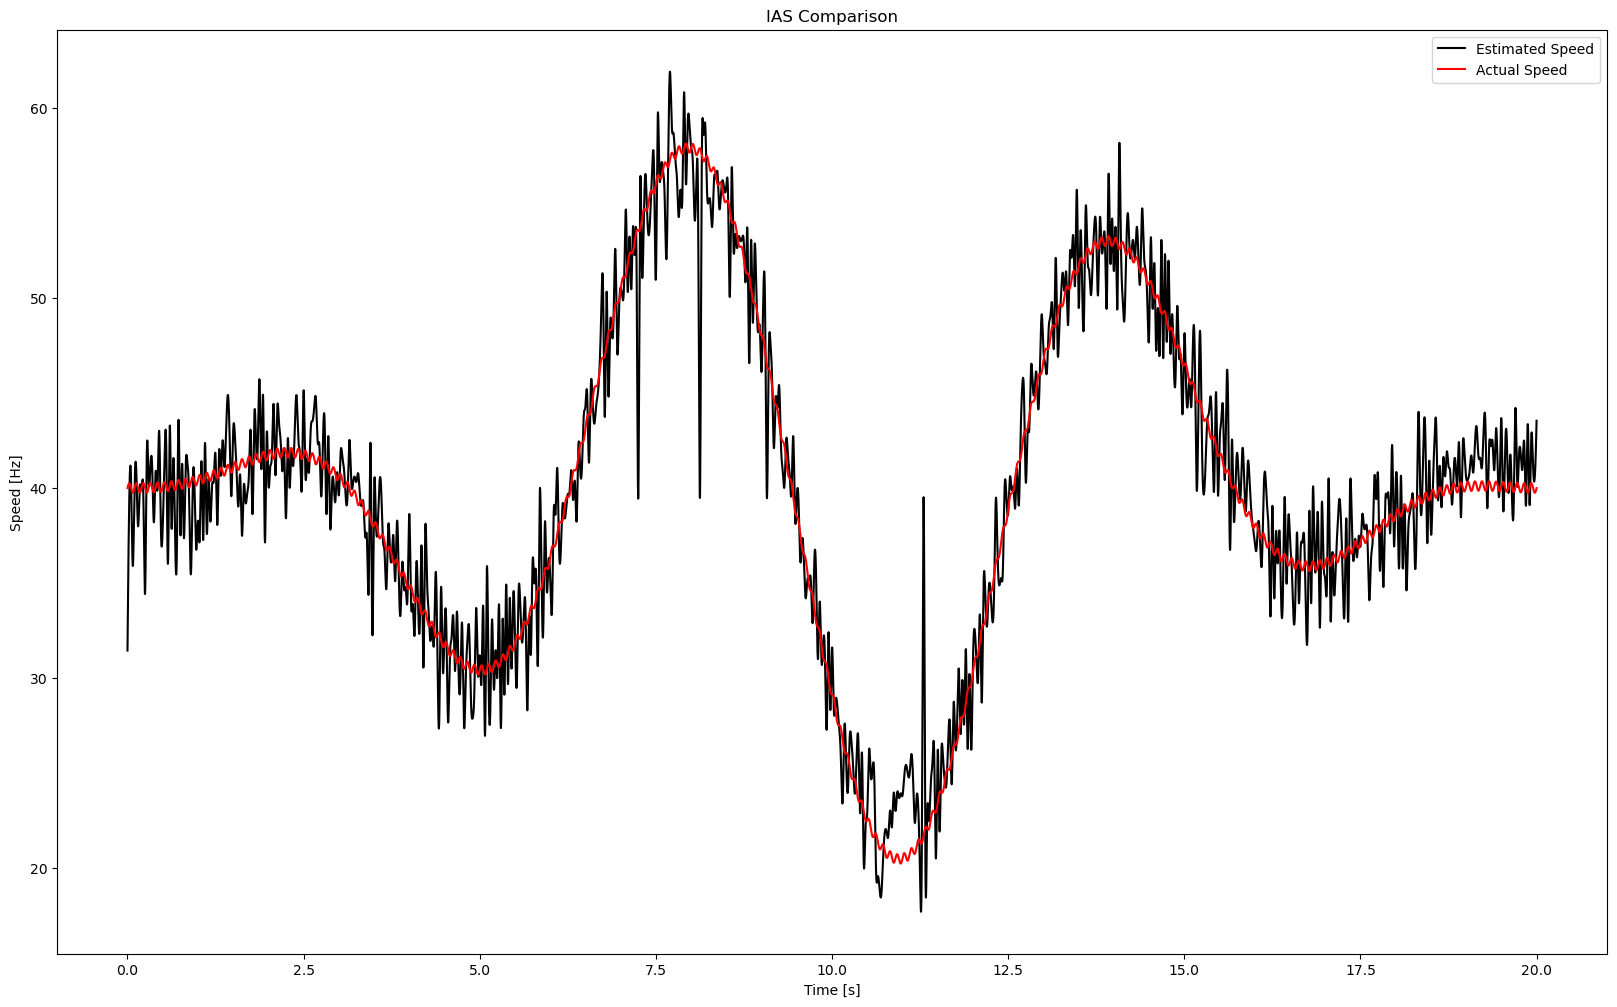

In [7]:
# Interpolate speed based on Fve
estimated_speed = interp1d(T, Fve, kind='cubic')(t)/order

plt.figure(figsize=(20, 12))
plt.plot(t, estimated_speed, 'k', linewidth=1.5, label='Estimated Speed')
plt.plot(t, speed, 'r', linewidth=1.5, label='Actual Speed')
plt.xlabel('Time [s]')
plt.ylabel('Speed [Hz]')
plt.title('IAS Comparison')
plt.legend()
plt.show()